In [1]:
import os
import zipfile
import kagglehub

# Download the dataset
kaggle_dataset_name = "hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages"
dataset_path = kagglehub.dataset_download(kaggle_dataset_name)
print("Dataset Path : ",dataset_path)

100%|██████████| 17.9G/17.9G [04:01<00:00, 79.7MB/s]

Extracting files...


Dataset Path :  /root/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1


In [11]:
data_path = "/root/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset"

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import librosa
import librosa.display

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Step 1: Load and Process Audio Dataset
class MFCCDataset(Dataset):
    def __init__(self, data_path, languages, n_mfcc=13, sr=16000):
        self.data = []
        self.labels = []
        self.label_encoder = LabelEncoder()
        self.languages = languages
        self.sr = sr
        self.n_mfcc = n_mfcc

        for lang in languages:
            print(f"Processing {lang}...")
            lang_path = os.path.join(data_path, lang)
            for file in os.listdir(lang_path):
                file_path = os.path.join(lang_path, file)
                if file.endswith(".mp3") and os.path.exists(file_path):
                  try:
                    file_path = os.path.join(lang_path, file)
                    audio, _ = librosa.load(file_path, sr=sr)  # Downsample to 16kHz
                    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc).mean(axis=1)
                    self.data.append(mfcc)
                    self.labels.append(lang)
                  except Exception as e:
                     print(f"Skipping {file}: {e}")
                else:
                  print(f"File not found: {file_path}")

        self.data = np.array(self.data)
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Step 2: Compute MFCC Statistics
def compute_mfcc_statistics(dataset):
    unique_labels = dataset.label_encoder.classes_
    stats = {}
    for i, lang in enumerate(unique_labels):
        lang_features = dataset.data[np.array(dataset.labels) == i]
        mean_mfcc = np.mean(lang_features, axis=0)
        var_mfcc = np.var(lang_features, axis=0)
        stats[lang] = {"mean": mean_mfcc, "variance": var_mfcc}

    for lang, stat in stats.items():
        print(f"Language: {lang}")
        print(f"Mean MFCC: {stat['mean']}")
        print(f"Variance MFCC: {stat['variance']}")
        print("--------------------------------------")
    return stats

# Step 3: Visualize MFCC Spectrograms
def visualize_mfcc_spectrograms(data_path, languages, n_mfcc=13, sr=16000,samples_per_lang=5):
    for lang in languages:
        lang_path = os.path.join(data_path, lang)
        files = [f for f in os.listdir(lang_path) if f.endswith(".mp3")][:samples_per_lang]
        if files:
            file_path = os.path.join(lang_path, files[0])  # Pick first file
            audio, _ = librosa.load(file_path, sr=sr)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mfcc, x_axis='time', sr=sr)
            plt.colorbar()
            plt.title(f"MFCC Spectrogram - {lang}")
            plt.xlabel("Time")
            plt.ylabel("MFCC Coefficients")
            plt.show()

# Step 4: Define Neural Network Classifier
class LanguageClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LanguageClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Step 5: Train and Evaluate Model
def train_classifier(dataset, num_epochs=20, batch_size=16, lr=0.001):
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = LanguageClassifier(input_size=dataset[0][0].shape[0], num_classes=len(dataset.label_encoder.classes_))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

    # Evaluation
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    print(f"Accuracy: {100 * correct / total:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues,xticks_rotation=45)
    plt.show()

languages = ["Hindi", "Bengali", "Tamil"]
dataset = MFCCDataset(data_path, languages)
compute_mfcc_statistics(dataset)
visualize_mfcc_spectrograms(data_path, languages)
train_classifier(dataset)


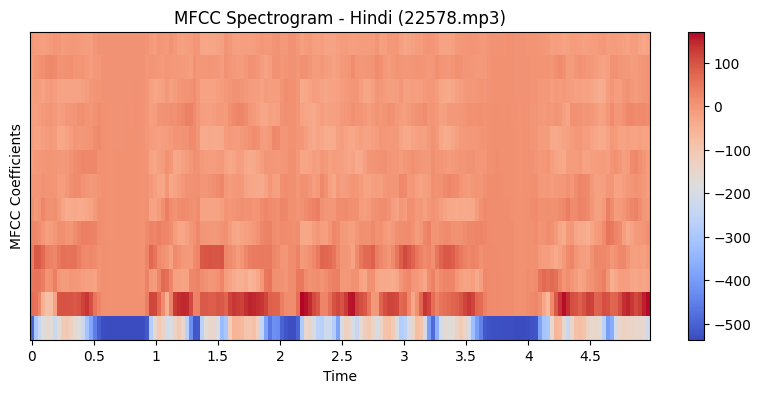

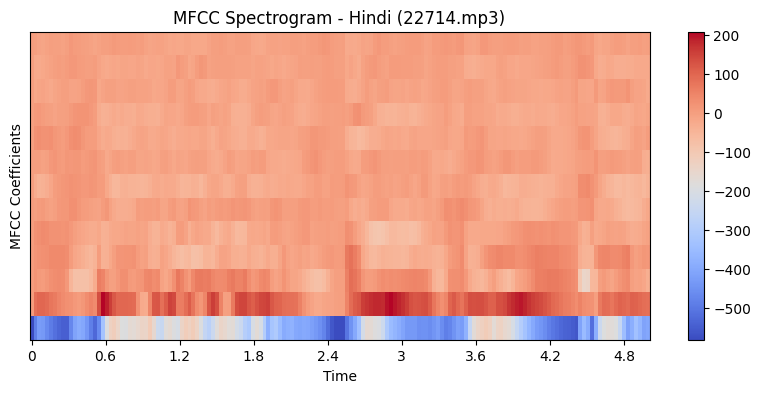

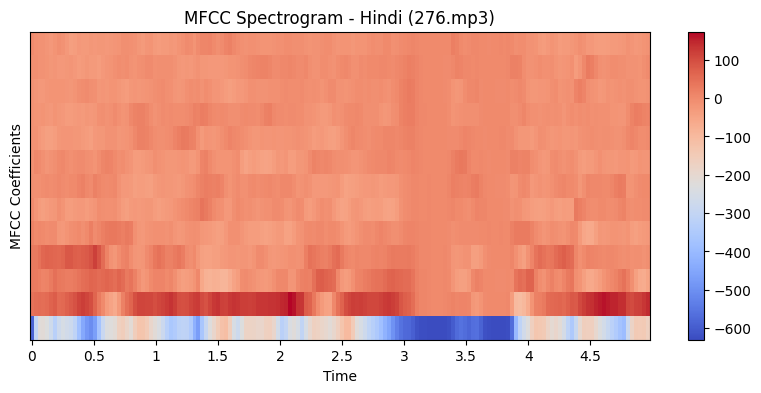

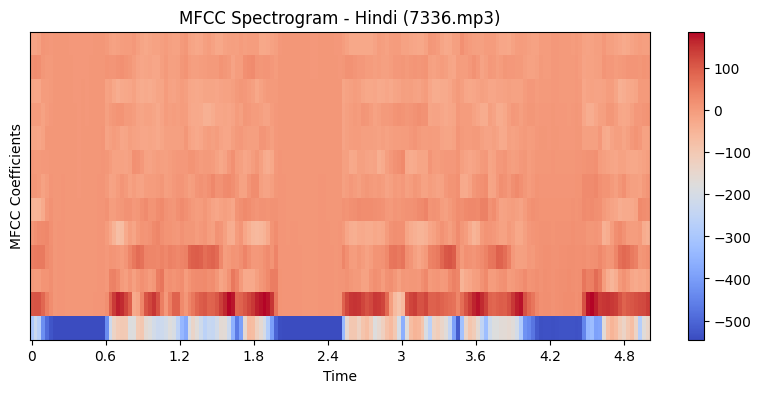

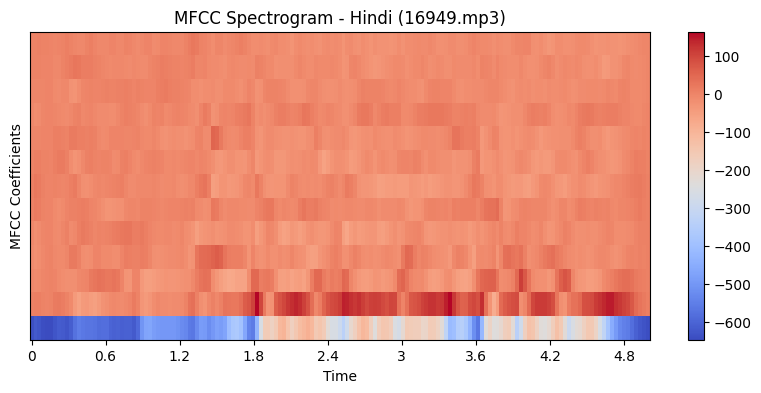

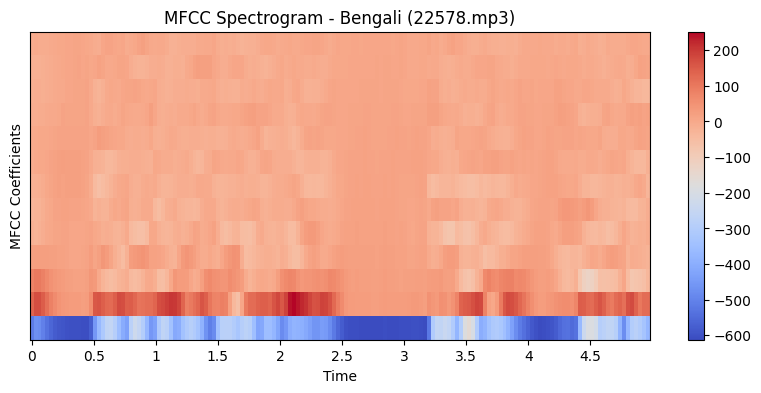

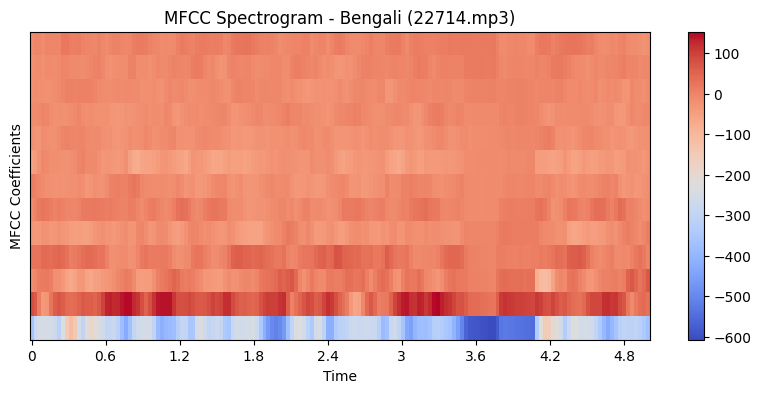

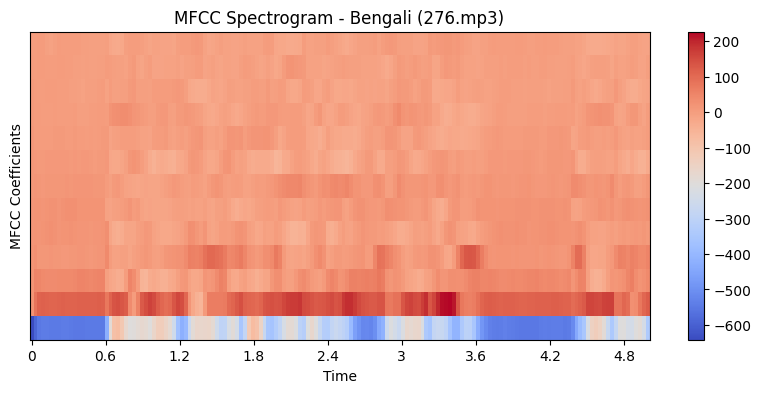

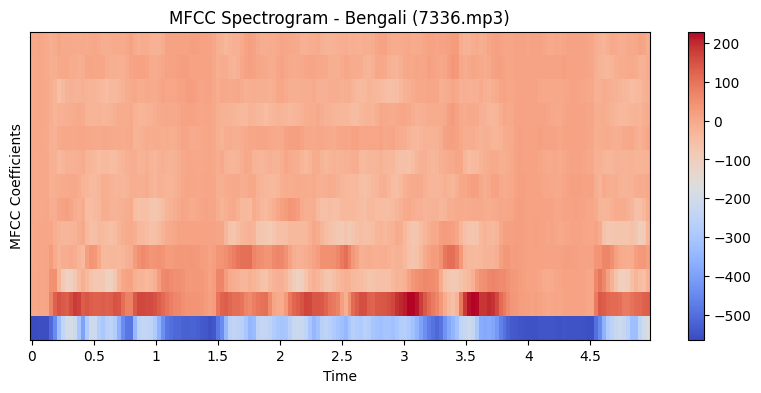

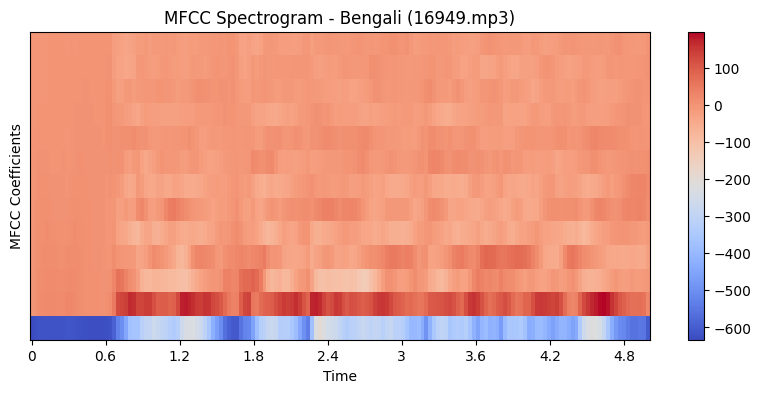

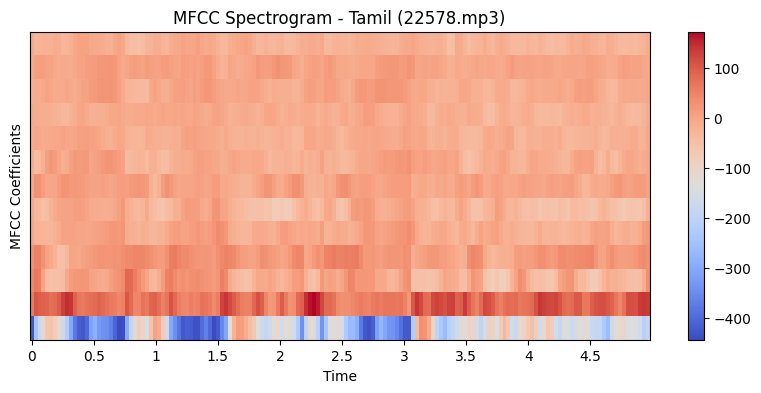

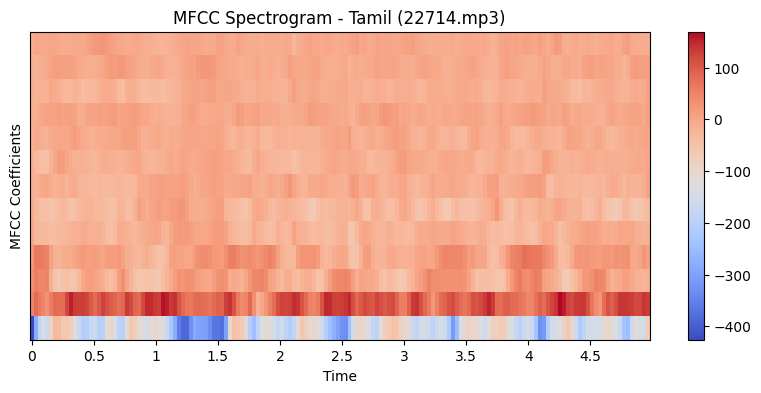

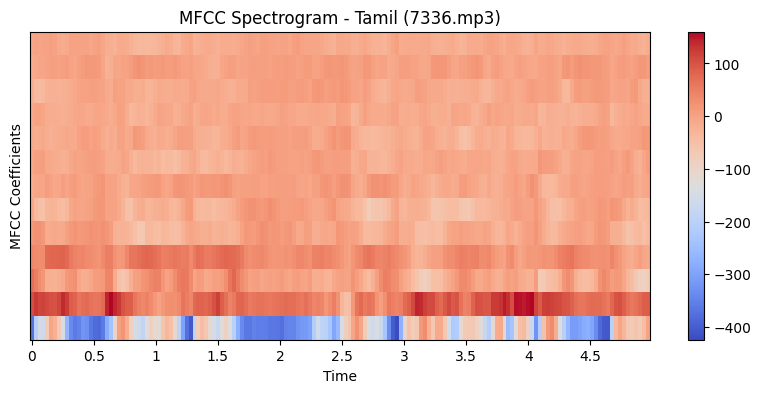

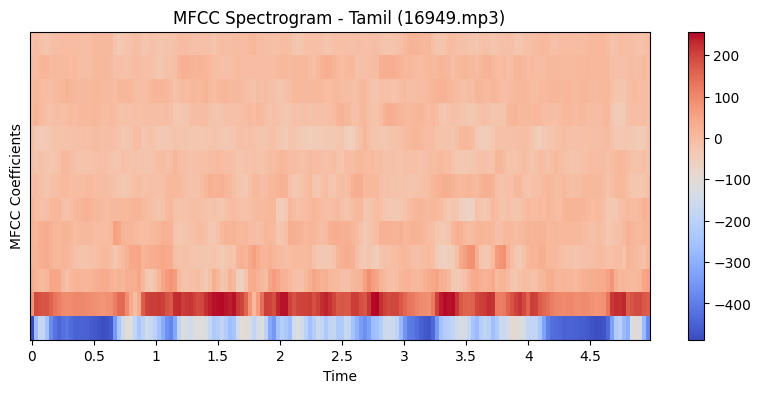

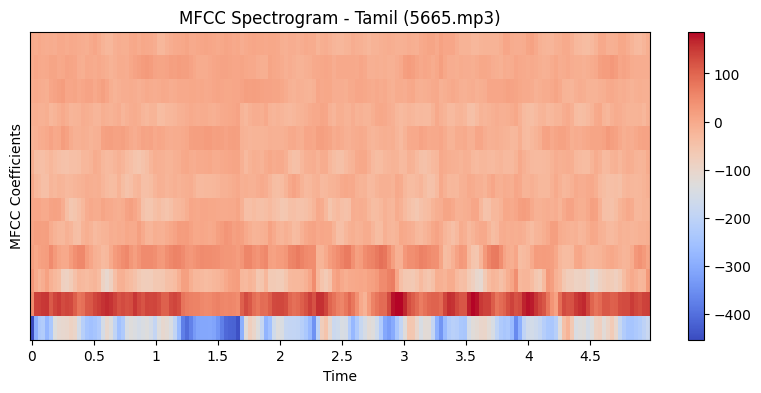

In [8]:
def visualize_mfcc_spectrograms(data_path, languages, n_mfcc=13, sr=16000, samples_per_lang=5):
    for lang in languages:
        lang_path = os.path.join(data_path, lang)
        files = [f for f in os.listdir(lang_path) if f.endswith(".mp3")]

        if len(files) < samples_per_lang:
            print(f"Warning: Not enough samples for {lang}. Found {len(files)}, expected {samples_per_lang}.")

        # Take min(samples_per_lang, available_files) to avoid index errors
        selected_files = files[:min(samples_per_lang, len(files))]

        for file in selected_files:
            file_path = os.path.join(lang_path, file)
            audio, _ = librosa.load(file_path, sr=sr)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mfcc, x_axis='time', sr=sr)
            plt.colorbar()
            plt.title(f"MFCC Spectrogram - {lang} ({file})")
            plt.xlabel("Time")
            plt.ylabel("MFCC Coefficients")
            plt.show()


visualize_mfcc_spectrograms(data_path, languages)


Epoch 1/20, Loss: 0.6103
Epoch 2/20, Loss: 0.3939
Epoch 3/20, Loss: 0.3577
Epoch 4/20, Loss: 0.3401
Epoch 5/20, Loss: 0.3292
Epoch 6/20, Loss: 0.3228
Epoch 7/20, Loss: 0.3169
Epoch 8/20, Loss: 0.3118
Epoch 9/20, Loss: 0.3090
Epoch 10/20, Loss: 0.3051
Epoch 11/20, Loss: 0.3035
Epoch 12/20, Loss: 0.3010
Epoch 13/20, Loss: 0.3001
Epoch 14/20, Loss: 0.2990
Epoch 15/20, Loss: 0.2969
Epoch 16/20, Loss: 0.2959
Epoch 17/20, Loss: 0.2953
Epoch 18/20, Loss: 0.2924
Epoch 19/20, Loss: 0.2920
Epoch 20/20, Loss: 0.2910
Accuracy: 85.30%


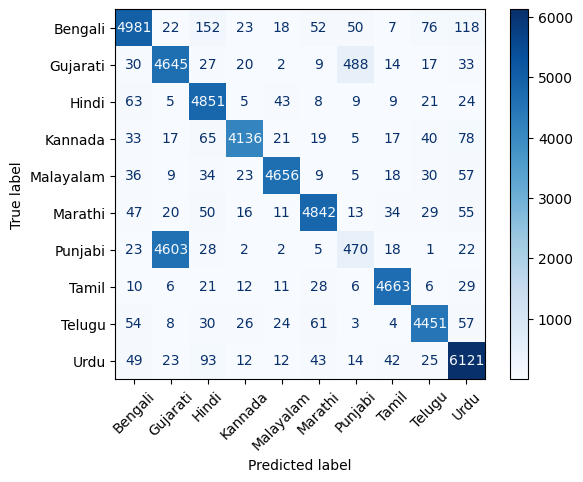

In [13]:
languages = ["Hindi", "Tamil", "Bengali", "Telugu", "Marathi", "Gujarati", "Kannada", "Malayalam", "Punjabi", "Urdu"]
dataset = MFCCDataset(data_path, languages)
compute_mfcc_statistics(dataset)
train_classifier(dataset)

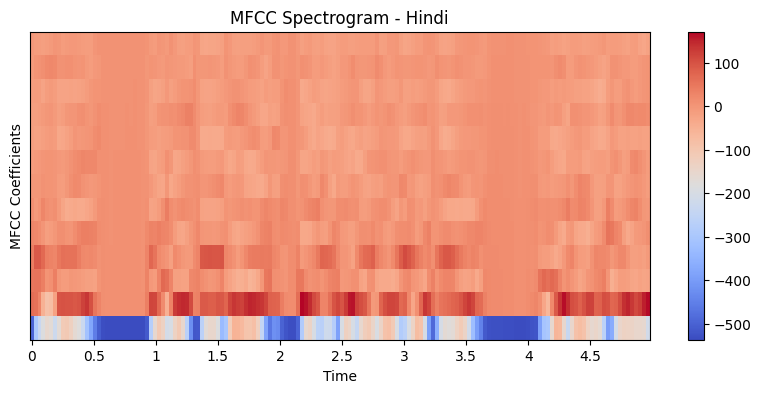

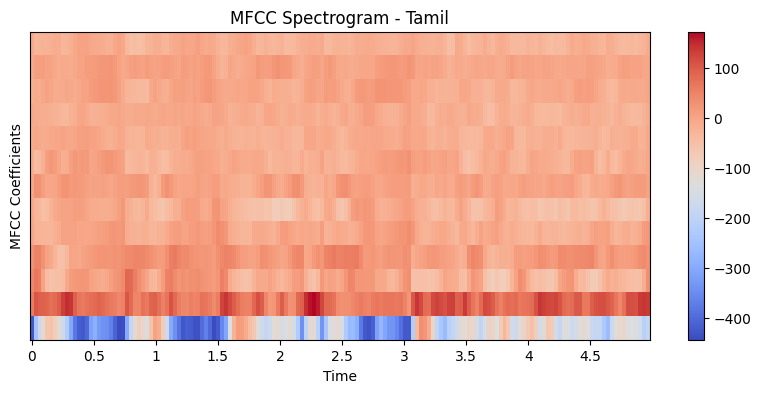

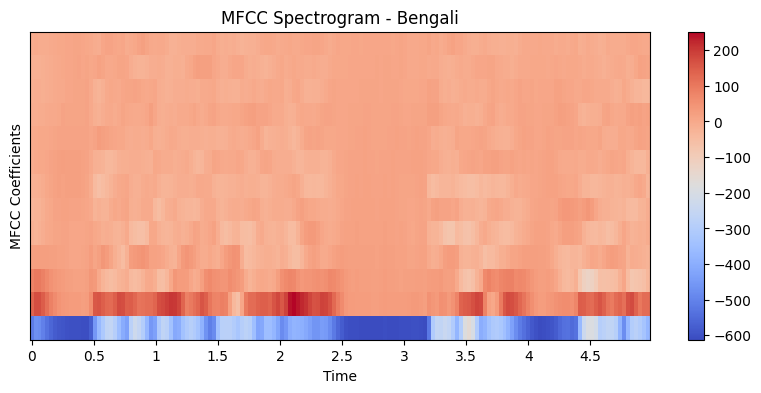

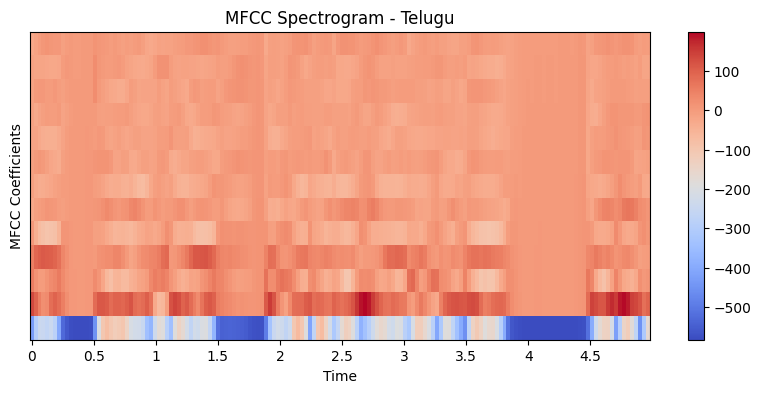

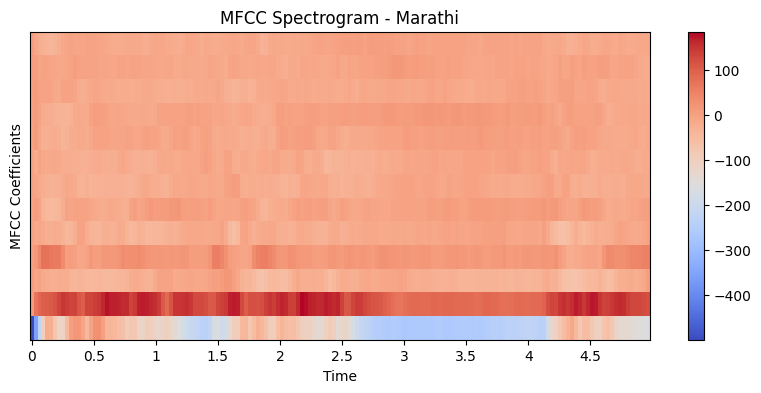

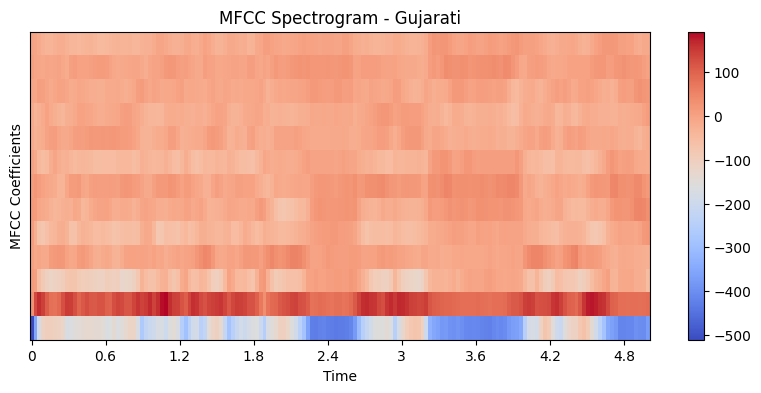

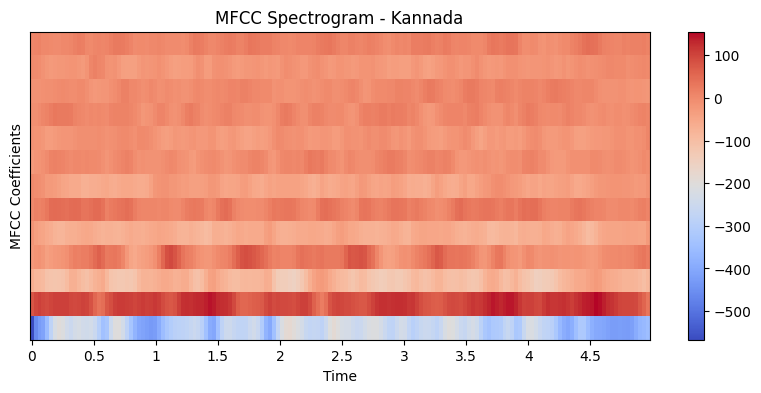

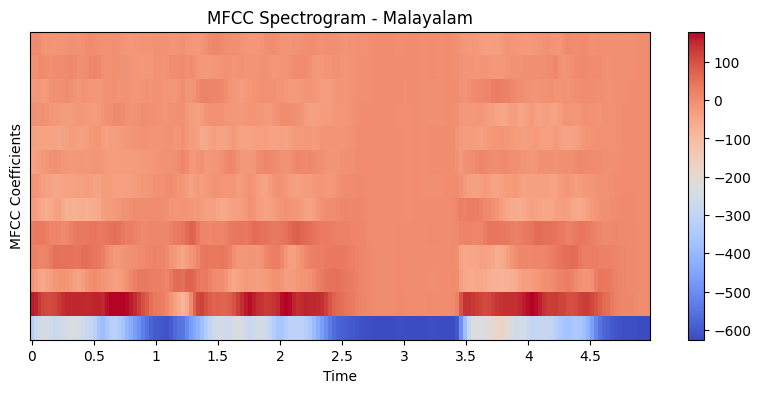

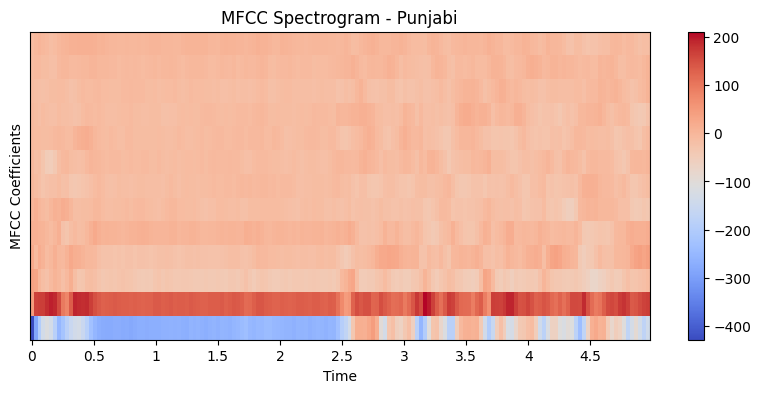

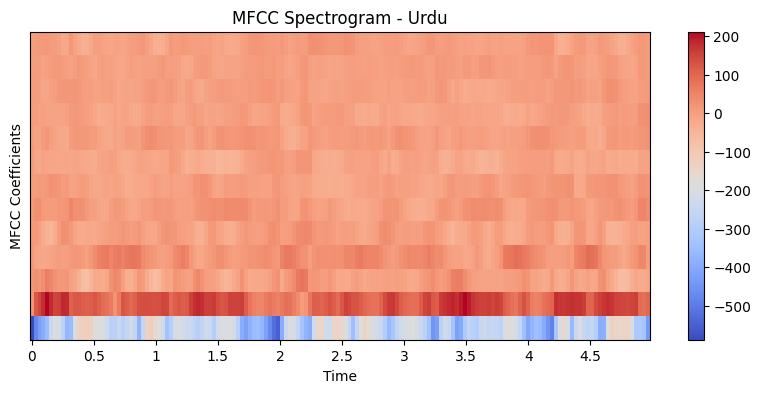

In [10]:
def visualize_mfcc_spectrograms_1(data_path, languages, n_mfcc=13, sr=16000):
    for lang in languages:
        lang_path = os.path.join(data_path, lang)
        files = [f for f in os.listdir(lang_path) if f.endswith(".mp3")]
        if files:
            file_path = os.path.join(lang_path, files[0])  # Pick first file
            audio, _ = librosa.load(file_path, sr=sr)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mfcc, x_axis='time', sr=sr)
            plt.colorbar()
            plt.title(f"MFCC Spectrogram - {lang}")
            plt.xlabel("Time")
            plt.ylabel("MFCC Coefficients")
            plt.show()

visualize_mfcc_spectrograms_1(data_path, languages)
